In [5]:
import pandas as pd
df = pd.read_stata("karlan_list_2007.dta")
df.head()

,treatment,control,ratio,ratio2,ratio3,size,size25,size50,size100,sizeno,...,redcty,bluecty,pwhite,pblack,page18_39,ave_hh_sz,median_hhincome,powner,psch_atlstba,pop_propurban
0,0,1,Control,0,0,Control,0,0,0,0,...,0.0,1.0,0.446493,0.527769,0.317591,2.10,28517.0,0.499807,0.324528,1.0
1,0,1,Control,0,0,Control,0,0,0,0,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,1,0,0,"$100,000",0,0,1,0,...,0.0,1.0,0.935706,0.011948,0.276128,2.48,51175.0,0.721941,0.192668,1.0
3,1,0,1,0,0,Unstated,0,0,0,1,...,1.0,0.0,0.888331,0.010760,0.279412,2.65,79269.0,0.920431,0.412142,1.0
4,1,0,1,0,0,"$50,000",0,1,0,0,...,0.0,1.0,0.759014,0.127421,0.442389,1.85,40908.0,0.416072,0.439965,1.0


In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

balance_vars = {
    'Months Since Last Donation': 'mrm2',
    'Highest Previous Contribution': 'hpa',
    'Number of Prior Donations': 'freq'
}

# T-tests and OLS regressions
ttest_results = {}
ols_results = {}

for label, var in balance_vars.items():
    control_vals = df[df['treatment'] == 0][var].dropna()
    treatment_vals = df[df['treatment'] == 1][var].dropna()
    t_stat, p_val = stats.ttest_ind(control_vals, treatment_vals, equal_var=False)
    ttest_results[label] = {'t_stat': t_stat, 'p_val': p_val}

    model = smf.ols(f"{var} ~ treatment", data=df).fit()
    coef = model.params['treatment']
    pval = model.pvalues['treatment']
    ols_results[label] = {'coef': coef, 'p_val': pval}

# Format for display
balance_summary = pd.DataFrame({
    'Variable': list(balance_vars.keys()),
    'T-test p-value': [ttest_results[v]['p_val'] for v in balance_vars],
    'OLS coef on treatment': [ols_results[v]['coef'] for v in balance_vars],
    'OLS p-value': [ols_results[v]['p_val'] for v in balance_vars]
})

balance_summary

,Variable,T-test p-value,OLS coef on treatment,OLS p-value
0,Months Since Last Donation,0.904855,0.013686,0.904886
1,Highest Previous Contribution,0.331840,0.637075,0.345099
2,Number of Prior Donations,0.911740,-0.011979,0.911702


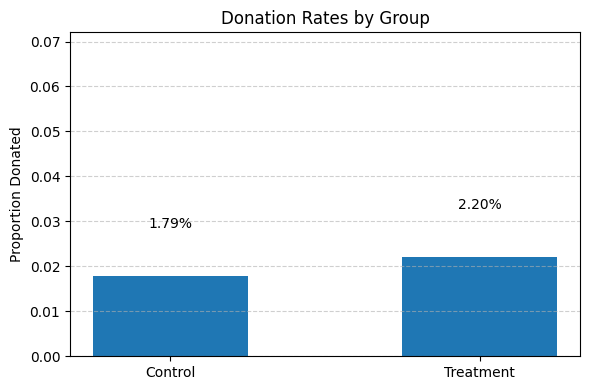

In [7]:
import matplotlib.pyplot as plt

# Calculate donation rates
donation_rates = df.groupby('treatment')['gave'].mean()
donation_rates.index = ['Control', 'Treatment']

# Create bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(donation_rates.index, donation_rates.values, width=0.5)
plt.ylabel('Proportion Donated')
plt.title('Donation Rates by Group')

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01,
             f'{height:.2%}', ha='center', va='bottom')

plt.ylim(0, max(donation_rates.values) + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

# T-test
control_group = df[df['treatment'] == 0]['gave']
treatment_group = df[df['treatment'] == 1]['gave']
t_stat, p_val = ttest_ind(treatment_group, control_group, equal_var=False)

# Regression
model = smf.ols("gave ~ treatment", data=df).fit()
reg_summary = model.summary()

t_stat, p_val, reg_summary

(np.float64(3.2094621908279835),
 np.float64(0.0013309823450914173),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                   gave   R-squared:                       0.000
 Model:                            OLS   Adj. R-squared:                  0.000
 Method:                 Least Squares   F-statistic:                     9.618
 Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00193
 Time:                        15:47:55   Log-Likelihood:                 26630.
 No. Observations:               50083   AIC:                        -5.326e+04
 Df Residuals:                   50081   BIC:                        -5.324e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 

In [10]:
import statsmodels.api as sm

probit_model = sm.Probit(df['gave'], sm.add_constant(df['treatment'])).fit()

# 计算平均边际效应
marginal_effects = probit_model.get_margeff()
marginal_effects.summary()

Optimization terminated successfully.
         Current function value: 0.100443
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                   gave
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0043      0.001      3.104      0.002       0.002       0.007
==============================================================================
"""

In [11]:
from scipy.stats import ttest_ind

# Only look at treatment group
df_match = df[df['treatment'] == 1]

# Define match groups
gave_1_1 = df_match[df_match['ratio'] == 1]['gave']
gave_2_1 = df_match[df_match['ratio'] == 2]['gave']
gave_3_1 = df_match[df_match['ratio'] == 3]['gave']

# T-tests
ttest_2v1 = ttest_ind(gave_2_1, gave_1_1, equal_var=False)
ttest_3v1 = ttest_ind(gave_3_1, gave_1_1, equal_var=False)

print("2:1 vs 1:1 p-value:", round(ttest_2v1.pvalue, 4))
print("3:1 vs 1:1 p-value:", round(ttest_3v1.pvalue, 4))

2:1 vs 1:1 p-value: 0.3345
3:1 vs 1:1 p-value: 0.3101


In [12]:
import statsmodels.formula.api as smf

# Filter treatment group only
df_match = df[df['treatment'] == 1]

# Linear regression: 1:1 match is the omitted category
model = smf.ols("gave ~ ratio2 + ratio3", data=df_match).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   gave   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6454
Date:                Mon, 21 Apr 2025   Prob (F-statistic):              0.524
Time:                        21:56:21   Log-Likelihood:                 16688.
No. Observations:               33396   AIC:                        -3.337e+04
Df Residuals:                   33393   BIC:                        -3.334e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0207      0.001     14.912      0.000       0.018       0.023
ratio2         0.0019      0.002      0.958      0.338      -0.002       0.006
ratio3         0.0020      0.002      1.008      0.313      -0.002       0.006
==============================================================================
Omnibus:                    38963.957   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2506478.937
Skew:                           6.511   Prob(JB):                         0.00
Kurtosis:                      43.394   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# Mean donation rates by ratio
mean_1_1 = df_match[df_match['ratio'] == 1]['gave'].mean()
mean_2_1 = df_match[df_match['ratio'] == 2]['gave'].mean()
mean_3_1 = df_match[df_match['ratio'] == 3]['gave'].mean()

diff_2v1 = mean_2_1 - mean_1_1
diff_3v2 = mean_3_1 - mean_2_1

print("Response rate (2:1 - 1:1):", round(diff_2v1, 4))
print("Response rate (3:1 - 2:1):", round(diff_3v2, 4))

Response rate (2:1 - 1:1): 0.0019
Response rate (3:1 - 2:1): 0.0001


In [14]:
# Keep only donors
donated = df[df['gave'] == 1]

# T-test: compare mean donation amounts
amount_treatment = donated[donated['treatment'] == 1]['amount']
amount_control = donated[donated['treatment'] == 0]['amount']
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(amount_treatment, amount_control, equal_var=False)

# Regression: amount ~ treatment
import statsmodels.formula.api as smf
model_amount = smf.ols("amount ~ treatment", data=donated).fit()
model_amount.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3374
Date:                Mon, 21 Apr 2025   Prob (F-statistic):              0.561
Time:                        22:07:00   Log-Likelihood:                -5326.8
No. Observations:                1034   AIC:                         1.066e+04
Df Residuals:                    1032   BIC:                         1.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.5403      2.423     18.792      0.000      40.785      50.296
treatment     -1.6684      2.872     -0.581      0.561      -7.305       3.968
==============================================================================
Omnibus:                      587.258   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5623.279
Skew:                           2.464   Prob(JB):                         0.00
Kurtosis:                      13.307   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

amount_control = df[df['treatment'] == 0]['amount']
amount_treatment = df[df['treatment'] == 1]['amount']
ttest_amount = ttest_ind(amount_treatment, amount_control, equal_var=False)

model_amount = smf.ols("amount ~ treatment", data=df).fit()
ttest_amount, model_amount.summary()

(TtestResult(statistic=np.float64(1.9182618934467577), pvalue=np.float64(0.05508566528918335), df=np.float64(36216.05660774625)),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 amount   R-squared:                       0.000
 Model:                            OLS   Adj. R-squared:                  0.000
 Method:                 Least Squares   F-statistic:                     3.461
 Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0628
 Time:                        22:09:56   Log-Likelihood:            -1.7946e+05
 No. Observations:               50083   AIC:                         3.589e+05
 Df Residuals:                   50081   BIC:                         3.589e+05
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  co

In [16]:
df_positive = df[df['gave'] == 1]
model_conditional = smf.ols("amount ~ treatment", data=df_positive).fit()
model_conditional.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3374
Date:                Mon, 21 Apr 2025   Prob (F-statistic):              0.561
Time:                        22:15:55   Log-Likelihood:                -5326.8
No. Observations:                1034   AIC:                         1.066e+04
Df Residuals:                    1032   BIC:                         1.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.5403      2.423     18.792      0.000      40.785      50.296
treatment     -1.6684      2.872     -0.581      0.561      -7.305       3.968
==============================================================================
Omnibus:                      587.258   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5623.279
Skew:                           2.464   Prob(JB):                         0.00
Kurtosis:                      13.307   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

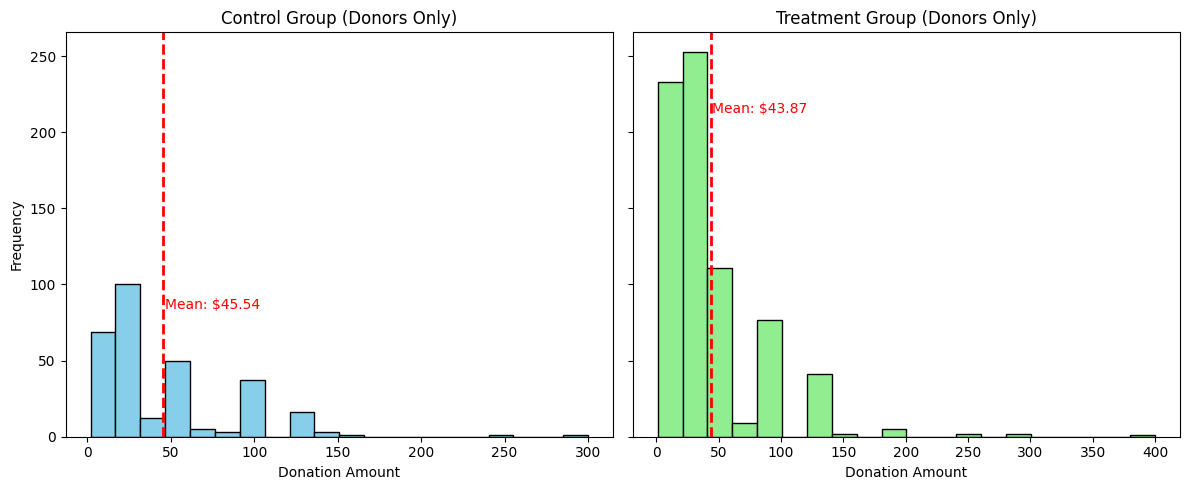

In [17]:
import matplotlib.pyplot as plt

donated_control = df[(df['gave'] == 1) & (df['treatment'] == 0)]['amount']
donated_treatment = df[(df['gave'] == 1) & (df['treatment'] == 1)]['amount']

mean_control = donated_control.mean()
mean_treatment = donated_treatment.mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Control group
axes[0].hist(donated_control, bins=20, color='skyblue', edgecolor='black')
axes[0].axvline(mean_control, color='red', linestyle='dashed', linewidth=2)
axes[0].set_title('Control Group (Donors Only)')
axes[0].set_xlabel('Donation Amount')
axes[0].set_ylabel('Frequency')
axes[0].text(mean_control + 1, axes[0].get_ylim()[1] * 0.8,
             f'Mean: ${mean_control:.2f}', color='red')

# Treatment group
axes[1].hist(donated_treatment, bins=20, color='lightgreen', edgecolor='black')
axes[1].axvline(mean_treatment, color='red', linestyle='dashed', linewidth=2)
axes[1].set_title('Treatment Group (Donors Only)')
axes[1].set_xlabel('Donation Amount')
axes[1].text(mean_treatment + 1, axes[1].get_ylim()[1] * 0.8,
             f'Mean: ${mean_treatment:.2f}', color='red')

plt.tight_layout()
plt.show()

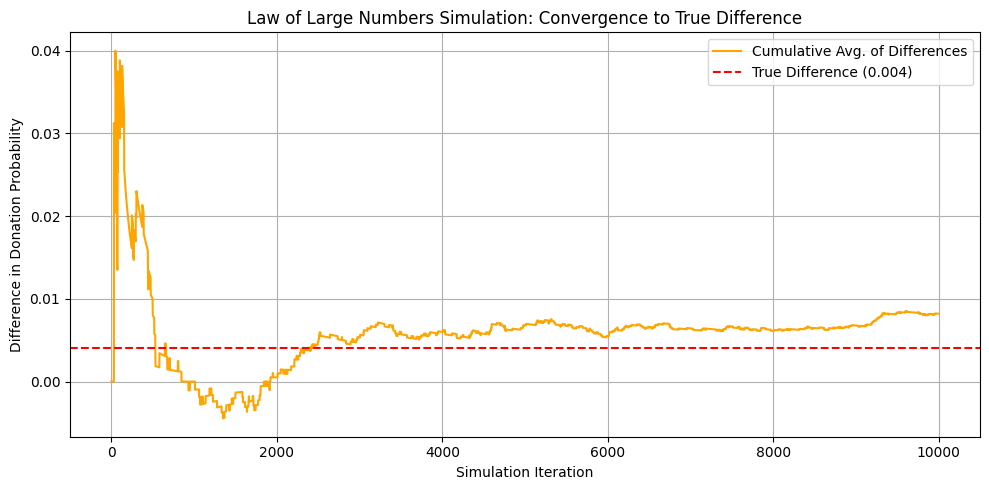

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Set probabilities
p_control = 0.018
p_treatment = 0.022
n_draws = 10000
np.random.seed(42)

# Simulate
control_draws = np.random.binomial(1, p_control, n_draws)
treatment_draws = np.random.binomial(1, p_treatment, n_draws)

# Difference vector
differences = treatment_draws - control_draws
cumulative_avg_diff = np.cumsum(differences) / np.arange(1, n_draws + 1)

# Plot
true_diff = p_treatment - p_control
plt.figure(figsize=(10, 5))
plt.plot(cumulative_avg_diff, label='Cumulative Avg. of Differences', color='orange')
plt.axhline(true_diff, color='red', linestyle='--', label='True Difference (0.004)')
plt.title("Law of Large Numbers Simulation: Convergence to True Difference")
plt.xlabel("Simulation Iteration")
plt.ylabel("Difference in Donation Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

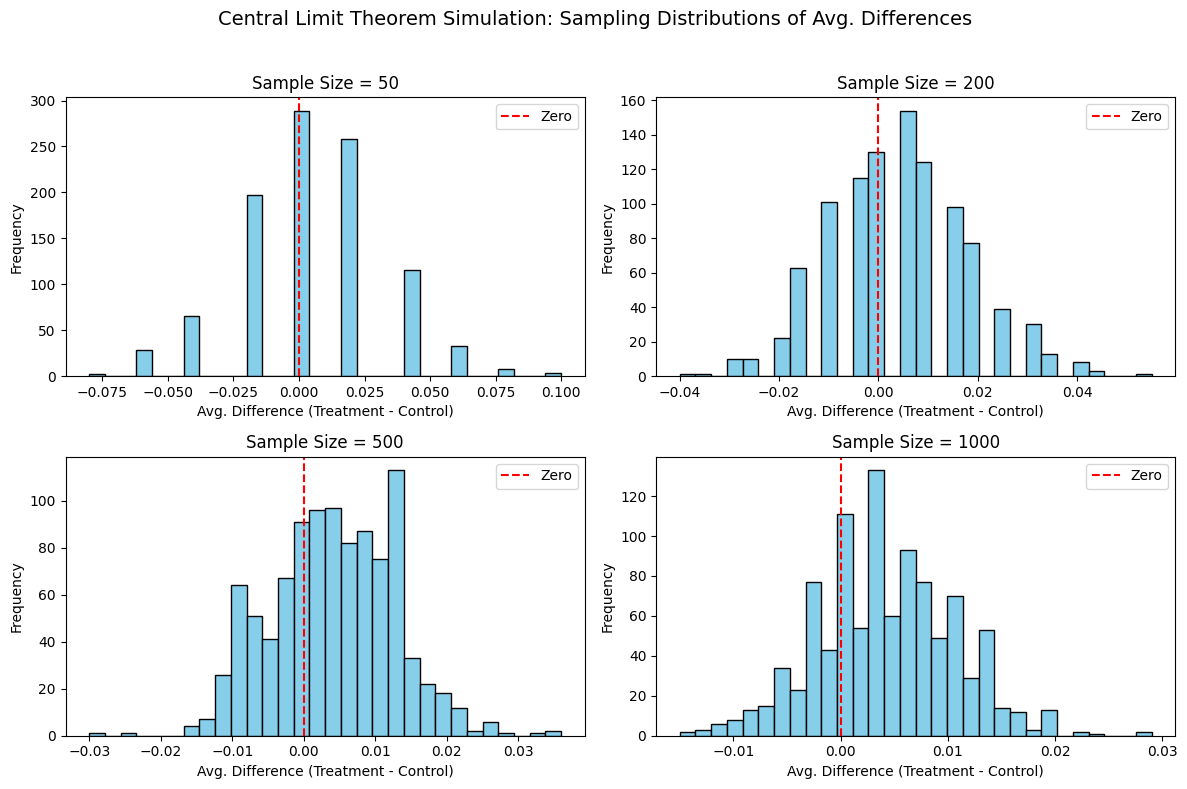

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 固定随机种子以保证结果可复现
np.random.seed(42)

# 设置参数
p_control = 0.018
p_treatment = 0.022
sample_sizes = [50, 200, 500, 1000]
n_simulations = 1000

# 创建子图容器
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# 对每个样本量进行模拟
for idx, n in enumerate(sample_sizes):
    avg_diffs = []  # 储存每次实验的均值差
    for _ in range(n_simulations):
        control_sample = np.random.binomial(1, p_control, n)
        treatment_sample = np.random.binomial(1, p_treatment, n)
        diff = treatment_sample.mean() - control_sample.mean()
        avg_diffs.append(diff)

    # 绘图
    axes[idx].hist(avg_diffs, bins=30, color='skyblue', edgecolor='black')
    axes[idx].axvline(0, color='red', linestyle='--', label='Zero')
    axes[idx].set_title(f"Sample Size = {n}")
    axes[idx].set_xlabel("Avg. Difference (Treatment - Control)")
    axes[idx].set_ylabel("Frequency")
    axes[idx].legend()

# 总标题和布局
plt.suptitle("Central Limit Theorem Simulation: Sampling Distributions of Avg. Differences", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()